In [1]:
devtools::install_github("clairbarnes/rwwa")
suppressMessages(library(rwwa))

rnm <- "kr"
nsamp <- 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify arguments for all models
hdwi_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
pr_args <- list(dist = "norm", type = "shift", varnm = "logx", covnm = c("gmst"), lower = T)
tx_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
wind_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
vpd_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
hursmin_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = T)

rp_list <- list("hdwi" = 100, "tx5x" = 100, "pr-fm" = 5, "sfcWindmax5x" = 5)

Skipping install of 'rwwa' from a github remote, the SHA1 (fad3047c) has not changed since last install.
  Use `force = TRUE` to force installation



# 3.1 - trends in HDWI

In [2]:
varnm <- "hdwi"

gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

ts <- load_ts("ts-kr/korea-fires_hdwi5x_ERA5land_kr.dat", col.names = c("year", "x"))
df <- merge(gmst, ts)

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr-fm" = pr_args, "tx5x" = tx_args, "sfcWindmax5x" = wind_args)
mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))

# # not sure why confidence region for return level plot isn't working, will compute manually
x_ci <- c(5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000)
# cov_f <- cov_2025; cov_cf <- cov_pi
# nsamp <- 1000
# set.seed(42)
# mdl_df <- mdl$data
# boot_res <- sapply(1:nsamp, function(i) {
#     boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T), ]
#     z <- tryCatch({
#         boot_mdl <- refit(mdl, boot_df)
#         c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), 
#           map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
#     }, error = function(cond) {
#         return(rep(NA, length(x_ci) * 2))
#     })
# })
# write.csv(boot_res, "boostrap-for-rlplot-ci_hdwi5x.csv", row.names = F)

boot_res <- read.csv("boostrap-for-rlplot-ci_hdwi5x.csv")
est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)

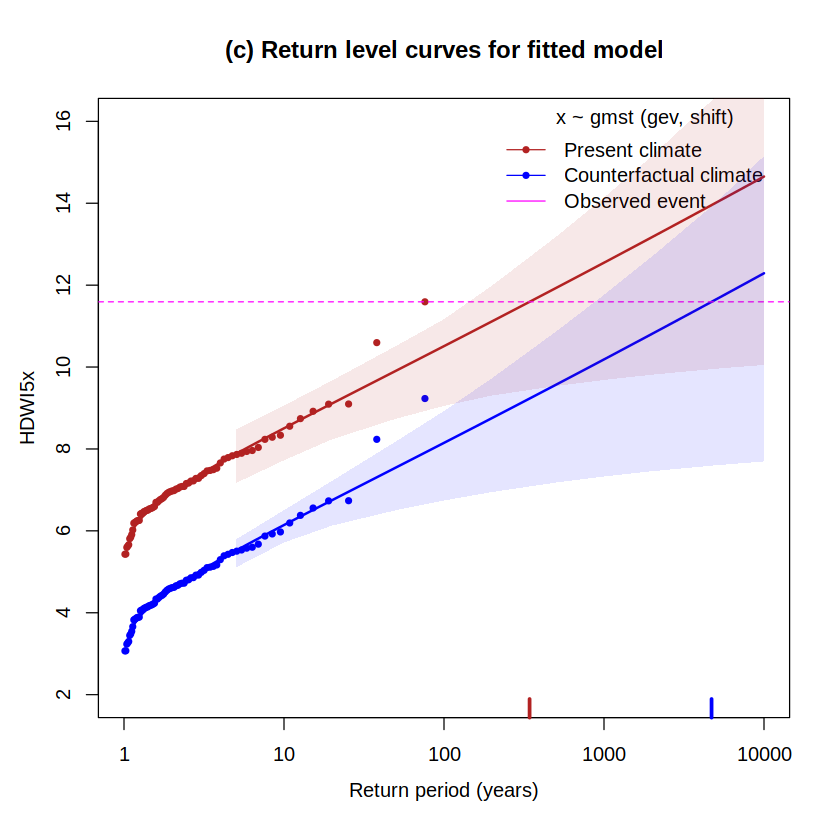

In [3]:
plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, nsamp = 10, ylab = "HDWI5x", main = "(c) Return level curves for fitted model")

In [7]:
png("fig/fig2-1_trend-in-hdwi.png", height = 360, width = 360 * 7/5*2); {
    prep_window(c(1,2), mar = c(3,4,3,1), lwd = 2)

    plot_trend(mdl, add_loess = T, xlab = "", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of time")
    plot_covtrend(mdl, "gmst", add_loess = T, xlab = "", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of GMST")
}; dev.off()

png 
  2

In [15]:
png("fig/fig2-1_trend-in-hdwi_with-RLplot.png", height = 240, width = 240 * 7/5*3); {
    prep_window(c(1,3), mar = c(4,4,3,1), lwd = 2)

    plot_trend(mdl, add_loess = T, xlab = "", ylab = "", main = "(a) Trend in March HDWI5x as a function of time")
    mtext("Year", line = 2.5, side = 1)
    mtext("HDWI5x", line = 2.5, side = 2)
    plot_covtrend(mdl, "gmst", add_loess = T, xlab = "GMST anomaly (degC)", ylab = "HDWI5x", main = "(a) Trend in March HDWI5x as a function of GMST")
    plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, nsamp = NA, ylab = "HDWI5x", main = "(c) Return level curves for fitted model")
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, 1:length(x_ci)], 
        rev(est_ci[2, 1:length(x_ci)])), density = NULL, 
        border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, -(1:length(x_ci))], 
        rev(est_ci[2, -(1:length(x_ci))])), density = NULL, 
        border = NA, col = adjustcolor("blue", 0.1))
}; dev.off()

png 
  2

# 3.2 - trends in HDWI components

In [11]:
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

hdwi <- load_ts("ts-kr/korea-fires_hdwi5x_ERA5land_kr.dat", col.names = c("year", "x"))
vpd <- load_ts("ts-kr/korea-fires_vpd5x_ERA5land_kr.dat", col.names = c("year", "x"))
tasmax <- load_ts("ts-kr/korea-fires_tx5x_ERA5land_kr.dat", col.names = c("year", "x"))
sfcWindmax1x <- load_ts("ts-kr/korea-fires_sfcWindmax1x_ERA5land_kr.dat", col.names = c("year", "x"))
sfcWindmax5x <- load_ts("ts-kr/korea-fires_sfcWindmax5x_ERA5land_kr.dat", col.names = c("year", "x"))
hursmin <- load_ts("ts-kr/korea-fires_hursmin5n_ERA5land_kr.dat", col.names = c("year", "x"))

In [12]:
# get actual values during HDWI spike
df <- read.csv("data/hdwi-vars_era5land_kr.csv")

In [13]:
event_values <- as.list(colMeans(df[(df$time >= "2025-03-22") & (df$time <= "2025-03-26") ,-1]))

In [14]:
ev1x <- df[df$time == "2025-03-25",]

In [15]:
mdl_vpd <- do.call(fit_ns, append(vpd_args, list("data" = merge(gmst, vpd), "ev" = event_values$vpdmax, "ev_year" = 2025)))
mdl_tasmax <- do.call(fit_ns, append(tx_args, list("data" = merge(gmst, tasmax), "ev" = event_values$tasmax, "ev_year" = 2025)))
mdl_wind <- do.call(fit_ns, append(wind_args, list("data" = merge(gmst, sfcWindmax1x))))
mdl_wind5x <- do.call(fit_ns, append(wind_args, list("data" = merge(gmst, sfcWindmax5x), "ev" = event_values$sfcWindmax, "ev_year" = 2025)))
mdl_hursmin <- do.call(fit_ns, append(hursmin_args, list("data" = merge(gmst, hursmin), "ev" = event_values$hursmin, "ev_year" = 2025)))

In [9]:
res = 200
png("fig/fig2-2_trends-in-hdwi-components.png", height = res*2, width = res * 2.5); {
    
    prep_window(c(2,2), mar = c(3,4,3,1), lwd = 2)

    plot_trend(mdl_wind, main = "(a) sfcWindmax1x", ylim = c(4,11), ylab = "", ev = ev1x$sfcWindmax, ev_year = 2025, add_loess = T, legend_pos = NA)
    mtext("Maximum daily windspeed (m/s)", line = 2.5, side = 2)
    plot_trend(mdl_vpd, main = "(b) vpd5x", ylim = c(0.5,3), ylab = "", ev = event_values$vpdmax, ev_year = 2025, add_loess = T, legend_pos = NA)
    mtext("Vapour-pressure deficit (kPa)", line = 2.5, side = 2)
    plot_trend(mdl_tasmax, main = "(c) tx5x", ylim = c(8,22), ylab = "", ev = event_values$tasmax, ev_year = 2025, add_loess = T, legend_pos = NA)
    mtext("Daily maximum temperatures (C)", line = 2.5, side = 2)
    plot_trend(mdl_hursmin, main = "(d) hursmin5n", ylim = c(20,50), ylab = "", ev = event_values$hursmin, ev_year = 2025, add_loess = T, legend_pos = NA)
    mtext("Relative humidity (%)", line = 2.5, side = 2)
    
}; dev.off()

png 
  2

In [16]:
res = 200
png("fig/fig2-3_gmsttrends-in-hdwi-components.png", height = res*2, width = res * 2.5); {
    
    prep_window(c(2,2), mar = c(3.5,4,3,1), lwd = 2)

    plot_covtrend(mdl_wind, "gmst", main = "(a) sfcWindmax1x", ylim = c(4,11), ylab = "", ev = ev1x$sfcWindmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Maximum daily windspeed (m/s)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_vpd, "gmst", main = "(b) vpd5x", ylim = c(0.5,3), ylab = "", ev = event_values$vpdmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Vapour-pressure deficit (kPa)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_tasmax, "gmst", main = "(c) tx5x", ylim = c(8,22), ylab = "", ev = event_values$tasmax, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Daily maximum temperatures (C)", line = 2.5, side = 2, cex = 0.8)
    plot_covtrend(mdl_hursmin, "gmst", main = "(d) hursmin5n", ylim = c(20,50), ylab = "", ev = event_values$hursmin, ev_x = 0, add_loess = T, legend_pos = NA)
    mtext("Relative humidity (%)", line = 2.5, side = 2, cex = 0.8)
    
}; dev.off()

png 
  2

In [14]:
cor(merge(merge(merge(merge(merge(load_ts("ts-kr/korea-fires_hdwi5x_ERA5land_kr.dat", col.names = c("year", "hdwi")),
      load_ts("ts-kr/korea-fires_vpd5x_ERA5land_kr.dat", col.names = c("year", "vpd"))),
                        load_ts("ts-kr/korea-fires_tx5x_ERA5land_kr.dat", col.names = c("year", "tx"))),
                  load_ts("ts-kr/korea-fires_sfcWindmax1x_ERA5land_kr.dat", col.names = c("year", "wind"))),
            load_ts("ts-kr/korea-fires_sfcWindmax5x_ERA5land_kr.dat", col.names = c("year", "wind5x"))),
      load_ts("ts-kr/korea-fires_hursmin5n_ERA5land_kr.dat", col.names = c("year", "hurs")))[,-1])

,hdwi,vpd,tx,wind,wind5x,hurs
hdwi,1.0000000,0.73786239,0.6198040,0.25480276,0.3296821,-0.43309758
vpd,0.7378624,1.00000000,0.8662305,0.09302409,0.1780678,-0.35632525
tx,0.6198040,0.86623048,1.0000000,0.06221210,0.1027548,-0.16797654
wind,0.2548028,0.09302409,0.0622121,1.00000000,0.6058526,-0.08033584
wind5x,0.3296821,0.17806783,0.1027548,0.60585263,1.0000000,-0.34544693
hurs,-0.4330976,-0.35632525,-0.1679765,-0.08033584,-0.3454469,1.00000000


In [ ]:
res_wind <- boot_ci(mdl_wind, cov_f = cov_2025, cov_cf = cov_pi)

res_vpd <- boot_ci(mdl_vpd, cov_f = cov_2025, cov_cf = cov_pi)
res_tasmax <- boot_ci(mdl_tasmax, cov_f = cov_2025, cov_cf = cov_pi)
res_hursmin <- boot_ci(mdl_hursmin, cov_f = cov_2025, cov_cf = cov_pi)

# compile results
obs_res <- t(sapply(list("sfcWindmax1x" = res_wind, "vpd5x" = res_vpd, "tx5x" = res_tasmax, "hursmin5n" = res_hursmin), function(res) {
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

write.csv(obs_res, "component-res.csv")

# 3.6 - trends in precip

In [16]:
varnm <- "pr-fm"

gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

ts <- load_ts("ts-kr/korea-fires_pr-fm_ERA5land_kr.dat", col.names = c("year", "x"))
df <- merge(gmst, ts)
df$logx = log(df$x)

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr-fm" = pr_args, "tx5x" = tx_args, "sfcWindmax5x" = wind_args)
mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))

# not sure why confidence region for return level plot isn't working, will compute manually
x_ci <- c(5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000)
# cov_f <- cov_2025; cov_cf <- cov_pi
# nsamp <- 1000
# set.seed(42)
# mdl_df <- mdl$data
# boot_res <- sapply(1:nsamp, function(i) {
#     boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T), ]
#     z <- tryCatch({
#         boot_mdl <- refit(mdl, boot_df)
#         c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), 
#           map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
#     }, error = function(cond) {
#         return(rep(NA, length(x_ci) * 2))
#     })
# })
# write.csv(boot_res, "boostrap-for-rlplot-ci_pr-fm.csv", row.names = F)

boot_res <- read.csv("boostrap-for-rlplot-ci_pr-fm.csv")
est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)

In [74]:
png("fig/fig3-6_trend-in-logpr_with-RLplot.png", height = 240, width = 240 * 7/5*3); {
    prep_window(c(1,3), mar = c(4,4,3,1), lwd = 2)

    plot_trend(mdl, add_loess = T, xlab = "", ylab = "", main = "(a) Trend in log(PR-FM) as a function of time")
    mtext("Year", line = 2.5, side = 1)
    mtext("log(PR-FM)", line = 2.5, side = 2)
    plot_covtrend(mdl, "gmst", add_loess = T, xlab = "GMST anomaly (degC)", ylab = "log(PR-FM)", main = "(a) Trend in log(PR-FM) as a function of GMST")
    plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, nsamp = NA, ylab = "log(PR-FM)", main = "(c) Return level curves for fitted model")
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, 1:length(x_ci)], 
        rev(est_ci[2, 1:length(x_ci)])), density = NULL, 
        border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1, -(1:length(x_ci))], 
        rev(est_ci[2, -(1:length(x_ci))])), density = NULL, 
        border = NA, col = adjustcolor("blue", 0.1))
}; dev.off()

png 
  2

In [75]:
png("fig/fig3-7_trend-in-pr_with-RLplot.png", height = 240, width = 240 * 7/5*3); {
    
    x <- mdl$x
    ev <- mdl$ev
    rp_x <- unique(c(seq(1.1, 2, 0.1), seq(2, 100, 1), seq(100, 
            1000, 10), seq(100, 1000, 100), seq(1000, 10000, 1000)))
    rp_th <- 1/seq(1, 0, length.out = length(x) + 2)[2:(length(x) + 
        1)]
    rl_curve_pres <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_f)
    rl_curve_cf <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_cf)
    rl_obs_pres <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_f)
    rl_obs_cf <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_cf)
    rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov_f)
    rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    prep_window(c(1,3), mar = c(4,4,3,1), lwd = 2)
    ylim = c(0,250)

    plot(df$year, df$x, type = "S", col = adjustcolor("black", 0.5), xlab = "", ylab = "", ylim = ylim, main = "(a) Trend in PR-FM as a function of time")
    lines(mdl$data$year - 0.5, exp(ns_pars(mdl)$loc), col = adjustcolor("black", 1), lwd = 2)

    lines(mdl$data$year - 0.5, exp(eff_return_level(mdl, 6)), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = 2)
    lines(mdl$data$year - 0.5, exp(eff_return_level(mdl, 40)), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = 1)

    points(2025, df$x[df$year == 2025], col = "magenta", lwd = 2, pch = 0)
    mtext("Year", line = 2.5, side = 1)
    mtext("Feb-March rainfall (mm)", line = 2.5, side = 2)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$x, pch = 20, xlab = "", ylab = "", col = adjustcolor("black", 0.6), ylim = ylim, main = "(a) Trend in PR-FM as a function of GMST")
    lines(mdl$data$gmst, exp(ns_pars(mdl)$loc), col = adjustcolor("black", 1), lwd = 2)

    lines(mdl$data$gmst, exp(eff_return_level(mdl, 6)), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = 2)
    lines(mdl$data$gmst, exp(eff_return_level(mdl, 40)), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = 1)

    points(0, df$x[df$year == 2025], col = "magenta", lwd = 2, pch = 0)
    mtext("GMST", line = 2.5, side = 1)
    mtext("Feb-March rainfall (mm)", line = 2.5, side = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(0, type = "n", log = "x", xlab = "", ylab = "", ylim = ylim, xlim = c(1, 10000), main = "(c) Return level curves for fitted model")

    lines(rp_x, exp(rl_curve_pres), lwd = 2, col = "firebrick", lty = 1)
    lines(rp_x, exp(rl_curve_cf), lwd = 2, col = "blue", lty = 1)
    points(rp_th, exp(sort(rl_obs_pres, decreasing = mdl$lower)), col = "firebrick")
    points(rp_th, exp(sort(rl_obs_cf, decreasing = mdl$lower)), col = "blue")
    abline(h = exp(ev), col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))

    polygon(x = c(x_ci, rev(x_ci)), y = exp(c(est_ci[1, 1:length(x_ci)], rev(est_ci[2, 1:length(x_ci)]))), density = NULL, border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = exp(c(est_ci[1, -(1:length(x_ci))], rev(est_ci[2, -(1:length(x_ci))]))), density = NULL, border = NA, col = adjustcolor("blue", 0.1))

    mtext("Return period", side = 1, line = 2.5, cex = par("cex.lab"))
    mtext("Feb-March rainfall (mm)", side = 2, line = 2.5, cex = par("cex.lab"))

}; dev.off()

png 
  2

In [89]:
df = read.csv("data/stations//stn_136_Andong_19730101-20250407.csv")
df[substr(df$date,6,7) %in% c("02","03")]

ERROR: Error in `[.data.frame`(df, substr(df$date, 6, 7) %in% c("02", "03")): undefined columns selected
